In [4]:
# import the plot funcitons 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# for the sake of rounding up
import math
import pandas as pd

In [6]:
# we get in the text file
def process_outputs(filename, sep_str):
    with open(filename, "r") as f:
        lines = f.read().splitlines() 

    print(len(lines))
    # split it into experiments 
    experiments = []

    for i,line in enumerate(lines):
        if sep_str in line:
            experiments.append(i)

    print(f"Number of experiments: {len(experiments)}")

    def get_acc(lines):

        def parse_line(line):
            if "matplotlib" in line:
                line = line.split("/")[0]
            info = line.split(",")
            return [float(info[x].split(":")[-1]) for x in range(3)]

        top_total_accs = 0
        top_accs = []
        for line in lines:
            if "Accuracy" in line:
                accs = parse_line(line)
                if accs[0] > top_total_accs:
                    top_accs = accs
        return top_accs

    names = []
    accs = []

    for i in range(len(experiments)-1):
        names.append(lines[experiments[i]])
        accs.append(get_acc(lines[experiments[i]:experiments[i+1]-1]))

    # for the last experiment 
    names.append(lines[experiments[i+1]])
    accs.append(get_acc(lines[experiments[i+1]:]))
    assert len(names) == len(experiments)
    assert len(names) == len(accs)
    return names, accs

def rename(names):
    new_names = []
    for i,name in enumerate(names):
        name = "_".join(name.split("_")[:-1])
        #info = name.split("_")
        #name = info[0] + info[-1]
        new_names.append(name)
            
    return new_names

#names, accs = process_outputs("run_vanilla.txt", "ModelCellsGPU")
#names2, accs2 = process_outputs("run_vanilla_part1.txt", "ModelCellsGPU")
#total_names = names + names2
#total_accs = accs + accs2
#total_names = rename(total_names)
names, accs = process_outputs("rnn_multilayer_with_dist.txt", "RNN")
names = rename(names)

87465
Number of experiments: 169


In [7]:
def get_average_acc(names, accs):
    # need to average over common named exeperiments 
    name_to_acc = {}
    for index,name in enumerate(names):
        if name in name_to_acc:
            name_to_acc[name].append(accs[index][0])
        else:
            name_to_acc[name] = [accs[index][0]]

    # now we get the average for each name 
    name_to_average_acc = []
    for key,vals in name_to_acc.items():
        name_to_average_acc.append((key,sum(vals)/len(vals)))

    sorted_by_second = sorted(name_to_average_acc, key=lambda tup: tup[1])
    for x in sorted_by_second:
        print(x)
    
get_average_acc(names, accs)

('RNNModelMultiLayer_1024_50', 51.73957218543499)
('RNNModelMultiLayer_1024_10', 51.81891680522705)
('RNNModelMultiLayer_1024_20', 52.13199060835956)
('RNNModelMultiLayer_2048,512_60', 52.20190532224664)
('RNNModelMultiLayer_1024_40', 52.2206496340169)
('RNNModelMultiLayer_2048,1024,512_10', 52.24679053056492)
('RNNModelMultiLayer_2048,512_10', 52.301798801540414)
('RNNModelMultiLayer_1024_30', 52.459705433675936)
('RNNModelMultiLayer_2048,512_50', 52.7514156634041)
('RNNModelMultiLayer_2048,512_40', 52.85945654582035)
('RNNModelMultiLayer_2048,512_20', 52.883238674960054)
('RNNModelMultiLayer_2048,1024,512_20', 52.90194210092939)
('RNNModelMultiLayer_2048,1024,512_60', 52.96132015297648)
('RNNModelMultiLayer_2048,1024,512_50', 53.07778041774505)
('RNNModelMultiLayer_2048,512_30', 53.15500630790475)
('RNNModelMultiLayer_2048,1024,512_30', 53.208462925598255)
('RNNModelMultiLayer_2048,1024,512_40', 53.252718953923214)


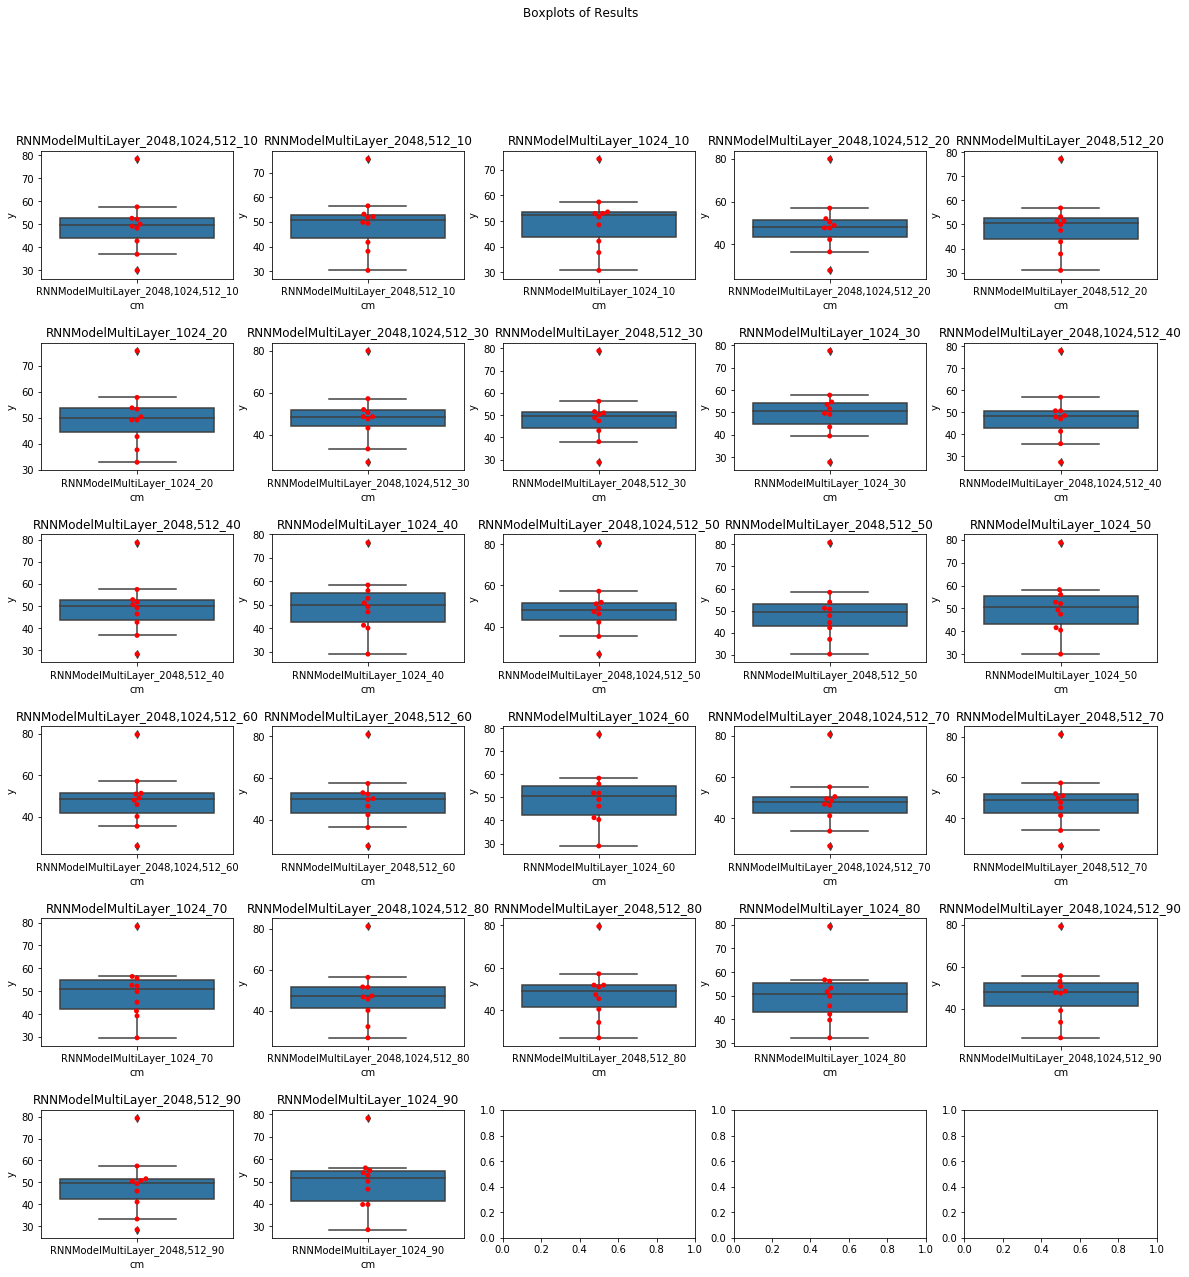

In [5]:
def dict_to_df(accs):
    Y = []
    X = []
    for key in accs:
        X.extend([key]*len(accs[key]))
        Y.extend(accs[key])

    return pd.DataFrame({"x":X, "y":Y})

def lists_to_dict(list1, list2):
    # Using zip() + loop + defaultdict() 
    # Merge key value list 
    res = {}
    for i, j in zip(list1, list2):
        total_acc = j[0]
        if i not in res:
            res[i] = [total_acc]
        else:
           res[i].append(total_acc) 
    return res

def make_box_plot(res):
    ncol = 5
    nrow = math.ceil(len(res) / ncol)

    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,20))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Boxplots of Results')

    for ax, data in zip(axes.flatten(), res.items()):
        #print(data)
        sns_data = dict_to_df({data[0]:data[1]})
        sns.boxplot(x="x",y="y", data=sns_data,ax=ax)
        sns.swarmplot(x="x",y="y", data=sns_data,ax=ax, color="red")
        #sns.stripplot(x='x', y='y', data=sns_data, jitter=True, ax=ax, color="red", edgecolor='none', alpha=.40)
        #sns.despine()
        #sns.violinplot(x="x", y="y",  data=dict_to_df({data[0]:data[1]}),ax=ax, scale='width', inner='quartile')
        ax.set(title=data[0], xlabel='cm')

    plt.show()

res = lists_to_dict(names, accs)
make_box_plot(res)

In [5]:
# now we process the sequence data
def process_outputs_seq(filename):
    with open(filename, "r") as f:
        lines = f.read().splitlines()

    # layer_names 
    layers = []
    number_of_class_one = []
    number_of_class_two = []
    total_accs = []
    last_accs = []
    for line in lines:
        if "Sequential" in line:
            layers.append(line)
        elif "class one" in line:
            number_of_class_one.append(int(line.split(":")[-1]))
        elif "class two" in line:
            number_of_class_two.append(int(line.split(":")[-1]))
        elif "Total Accuracy" in line:
            total_accs.append(float(line.split(",")[0].split(":")[-1]))
        elif "Last Accuracy" in line:
            last_accs.append(float(line.split(":")[-1]))
    return layers, number_of_class_one, number_of_class_two, total_accs, last_accs
            

def get_order(layers, number_of_class_one, number_of_class_two, accs):
    def get_avgs(number_of_class_one, number_of_class_two, accs):
        vals = []
        for i,sample in enumerate(zip(number_of_class_one,number_of_class_two)):
            num, num2 = sample
            vals.append(accs[i])
        output = sum(vals)/len(vals)
        return output

    def sort_acc(name_to_average_acc):
        sorted_by_second = sorted(name_to_average_acc, key=lambda tup: tup[1])
        for x in sorted_by_second:
            print(x)

    seq_names = []
    seq_accs = []
    for i in range(25):
        seq_names.append(layers[i])
        seq_accs.append(get_avgs(number_of_class_one[i:i+10], number_of_class_two[i:i+10], accs[i:i+10]))
    sort_acc(zip(seq_names, seq_accs))

filename = "run_all_seq_uneven_seeds.txt"
layers, number_of_class_one, number_of_class_two, total_accs, last_accs = process_outputs_seq(filename)
get_order(layers, number_of_class_one, number_of_class_two, last_accs)

('SequentialModel_128,32,16', 52.465284715284724)
('SequentialModel_128,64', 52.82581307581307)
('SequentialModel_128,32', 52.82581307581307)
('SequentialModel_128,16', 52.82581307581307)
('SequentialModel_64,32', 52.82581307581307)
('SequentialModel_64,16', 53.03414640914641)
('SequentialModel_128,8', 53.82581307581307)
('SequentialModel_128,64,8', 53.90972915972916)
('SequentialModel_64,8', 54.18799256299256)
('SequentialModel_128,64,32', 54.364274614274606)
('SequentialModel_128,64,16', 54.364274614274606)
('SequentialModel_128,16,8', 54.39584027084027)
('SequentialModel_32,16', 54.57260794760795)
('SequentialModel_32,8', 54.57260794760795)
('SequentialModel_16,8', 54.57260794760795)
('SequentialModel_128,32,8', 55.02084027084027)
('SequentialModel_16', 55.11747974247974)
('SequentialModel_8', 55.11747974247974)
('SequentialModel_32,16,8', 56.28894716394717)
('SequentialModel_32', 56.78414640914642)
('SequentialModel_128', 57.1687617937618)
('SequentialModel_64', 57.1687617937618)
(

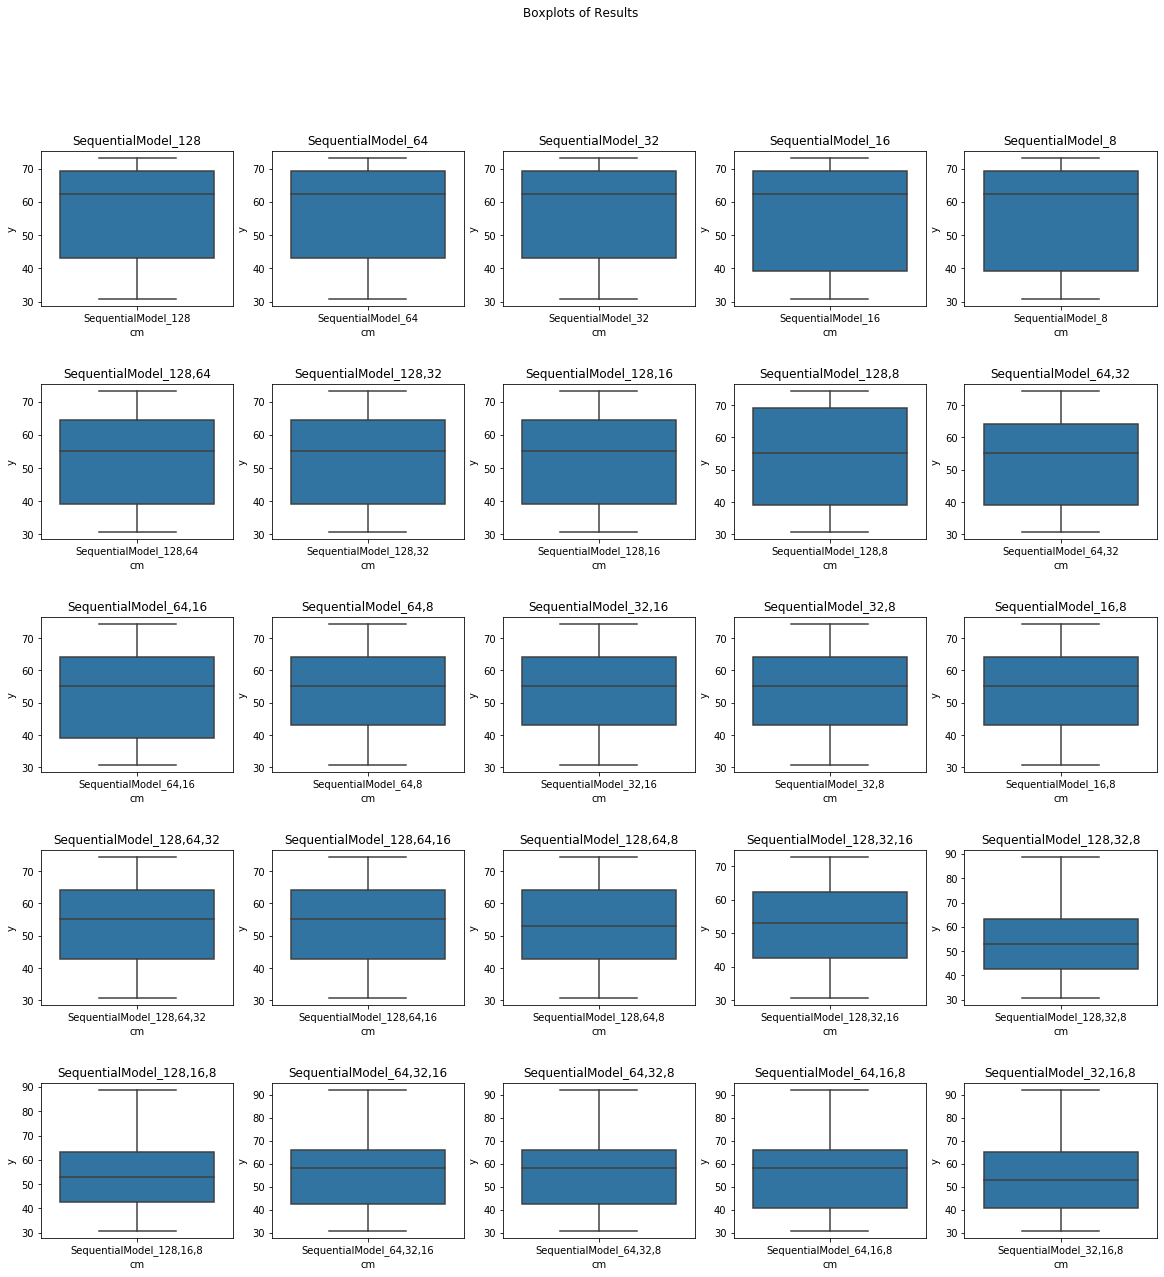

In [6]:
# get the average accuracies 
from collections import defaultdict 

seq_names = []
seq_accs = []
for i in range(25):
    for j in range(10):
        seq_names.append(layers[i])
        seq_accs.append(last_accs[i+j])

res = defaultdict(list) 
for i, j in zip(seq_names, seq_accs): 
   res[i].append(j) 
  
make_box_plot(res)